In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import os

from supervised_localization_train import (
    load_dataset, filter_dataset, sample_batch, random_crop, random_crop_batch, center_crop, center_crop_batch)

from softlearning.models.convnet import convnet_model
from softlearning.models.feedforward import feedforward_model

from softlearning.keras.layers import AddCoord2D

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
def sample_batch_unique(dataset, batch_size):
    num_samples = dataset["pixels"].shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    indices = indices[:batch_size]
    pixels = dataset["pixels"][indices]
    nearest_pos = dataset["nearest_pos"][indices]
    return pixels, nearest_pos

In [5]:
filepath = "~/softlearning_results/supervised_localization_2020-09-03T21-13-50/dataset.npy"
dataset = load_dataset(filepath)
dataset = filter_dataset(dataset)
dataset["pixels"].shape

(42170, 100, 100, 3)

In [6]:
validation_filepath = "~/softlearning_results/supervised_localization_2020-09-03T21-12-20/dataset.npy"
validation_dataset = load_dataset(validation_filepath)
validation_dataset = filter_dataset(validation_dataset)
validation_dataset["pixels"].shape

(8801, 100, 100, 3)

In [14]:
# # image_size = 100
# image_size = 96
# inputs = tf.keras.Input((image_size, image_size, 3))
# # model
# convnet = convnet_model(
#     conv_filters=(64, 64, 128, 128, 128),
#     conv_kernel_sizes=(3, 3, 3, 3, 3),
#     conv_strides=(2, 2, 2, 2, 1),
#     downsampling_type="conv",
#     normalization_type=None
# )
# # model_2
# # convnet = convnet_model(
# #     conv_filters=(64, 64, 64),
# #     conv_kernel_sizes=(3, 3, 3),
# #     conv_strides=(2, 2, 2),
# #     downsampling_type="conv",
# #     normalization_type=None
# # )
# conv_out = convnet(inputs)
# h = tf.keras.layers.Dense(512, activation="linear")(conv_out)
# h = tf.keras.layers.LeakyReLU()(h)
# h = tf.keras.layers.Dense(512, activation="linear")(h)
# h = tf.keras.layers.LeakyReLU()(h)
# outputs = tf.keras.layers.Dense(2, activation="linear")(h)
# model = tf.keras.Model(inputs, outputs)

image_size = 100
inputs = tf.keras.Input((image_size, image_size, 3))
# model_6
convnet = convnet_model(
    conv_filters=(128, 128, 128, 128),
    conv_kernel_sizes=(3, 3, 3, 3),
    conv_strides=(2, 2, 2, 2),
    conv_add_coords=(False, False, False, False),
    downsampling_type="conv",
    normalization_type=None,
    activation="relu"
)
conv_out = convnet(inputs)
# conv_out = convnet(inputs)
h = tf.keras.layers.Dense(512, activation="relu")(conv_out)
h = tf.keras.layers.Dense(512, activation="relu")(h)
outputs = tf.keras.layers.Dense(2, activation="linear")(h)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
convnet (Sequential)         (None, 6272)              446336    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               3211776   
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1026      
Total params: 3,921,794
Trainable params: 3,921,794
Non-trainable params: 0
_________________________________________________________________


In [15]:
savepath = os.path.join(os.path.dirname(os.path.expanduser(filepath)), "model_13")
model.load_weights(savepath)

Text(0, 0.5, 'prediction error (m)')

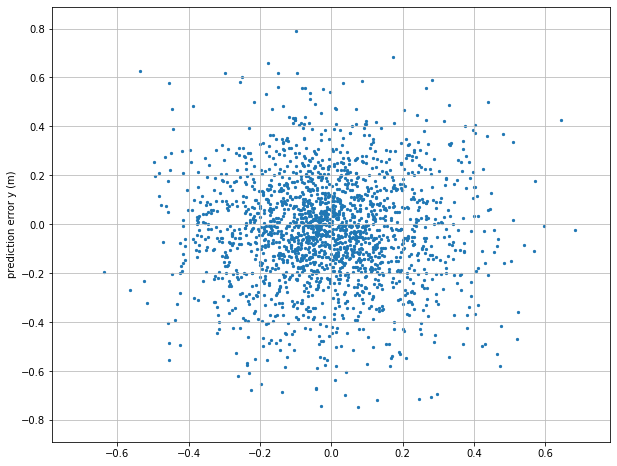

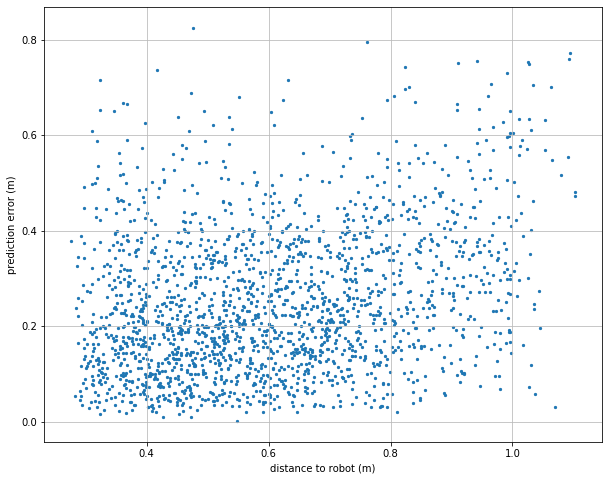

In [17]:
# pixels, pos = sample_batch_unique(dataset, 2000)
pixels, pos = sample_batch_unique(validation_dataset, 2000)
# pixels = center_crop_batch(pixels, image_size)
predicted_pos = model(pixels).numpy()

plt.figure(figsize=(10, 8))
x_error = pos[:, 0] - predicted_pos[:, 0]
y_error = pos[:, 1] - predicted_pos[:, 1]

xlim = max(np.abs(np.min(x_error)), np.abs(np.max(x_error))) + 0.1
ylim = max(np.abs(np.min(y_error)), np.abs(np.max(y_error))) + 0.1
plt.xlim(-xlim, xlim)
plt.ylim(-ylim, ylim)

plt.grid(b=True, which='major', color='#BBBBBB', linestyle='-')
plt.scatter(x_error, y_error, s=5)
plt.ylabel("prediction error x (m)")
plt.ylabel("prediction error y (m)")

plt.figure(figsize=(10, 8))
distance = np.sqrt(np.sum(pos ** 2, axis=-1))
error = np.sqrt(np.sum((pos - predicted_pos) ** 2, axis=-1))

plt.grid(b=True, which='major', color='#BBBBBB', linestyle='-')
plt.scatter(distance, error, s=5)

plt.xlabel("distance to robot (m)")
plt.ylabel("prediction error (m)")

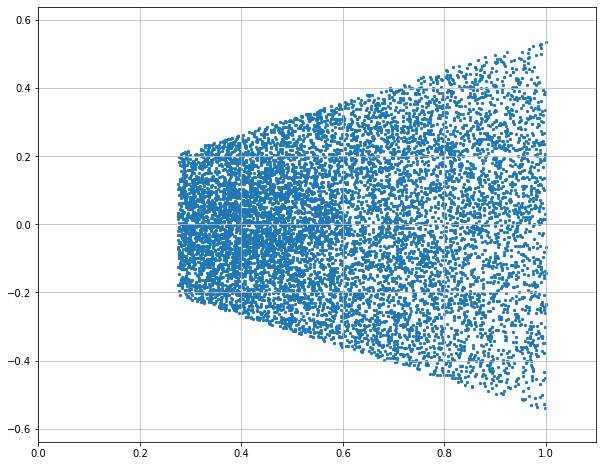

In [13]:
pixels, pos = sample_batch_unique(dataset, 10000)
# pixels, pos = sample_batch_unique(validation_dataset, 2000)
# pixels = center_crop_batch(pixels, image_size)
# predicted_pos = model(pixels).numpy()

plt.figure(figsize=(10, 8))
x_error = pos[:, 0]
y_error = pos[:, 1]

xlim = max(np.abs(np.min(x_error)), np.abs(np.max(x_error))) + 0.1
ylim = max(np.abs(np.min(y_error)), np.abs(np.max(y_error))) + 0.1
plt.xlim(0, xlim)
plt.ylim(-ylim, ylim)

plt.grid(b=True, which='major', color='#BBBBBB', linestyle='-')
plt.scatter(x_error, y_error, s=5)

array([1.3397615, 0.8668326], dtype=float32)

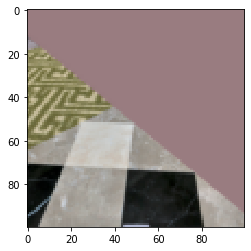

In [54]:
ind = np.argmax(dataset["nearest_pos"][:, 1])

img = dataset["pixels"][ind]
pos = dataset["nearest_pos"][ind]

plt.imshow(img)
pos

(96, 96, 3)

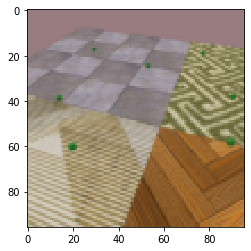

In [72]:
cropped = center_crop(img, 96)
plt.imshow(cropped)
cropped.shape

In [61]:
imgs = dataset["pixels"][10:15]
croppeds = random_crop_batch(imgs, 96)
# plt.imshow(img)
# img.shape